YOLOv3 Hyperparameters:
 - Target Size: (416, 416)
 - Confidence Threshold: 0.3
 - NMS Threshold: 0.4
 - Batch Size: 1

Processing personal images...
Processing image 1: personal_img1.webp
Detection took 0.693 seconds
Found 7 objects


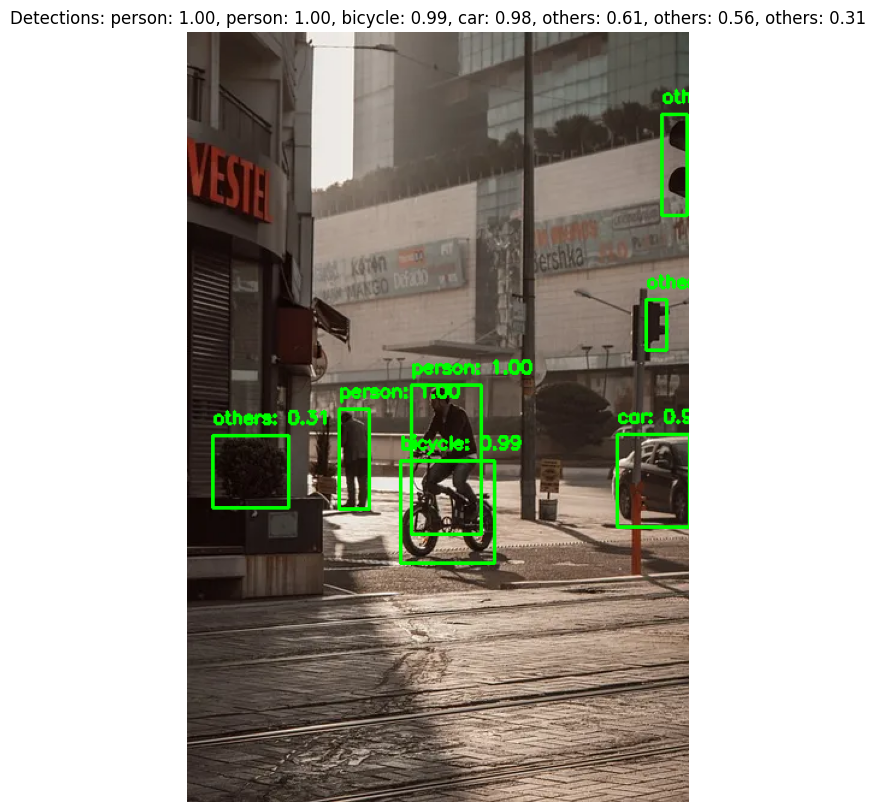

Result saved to detection_results/result_1.jpg
Processing image 2: personal_img2.jpeg
Detection took 0.700 seconds
Found 35 objects


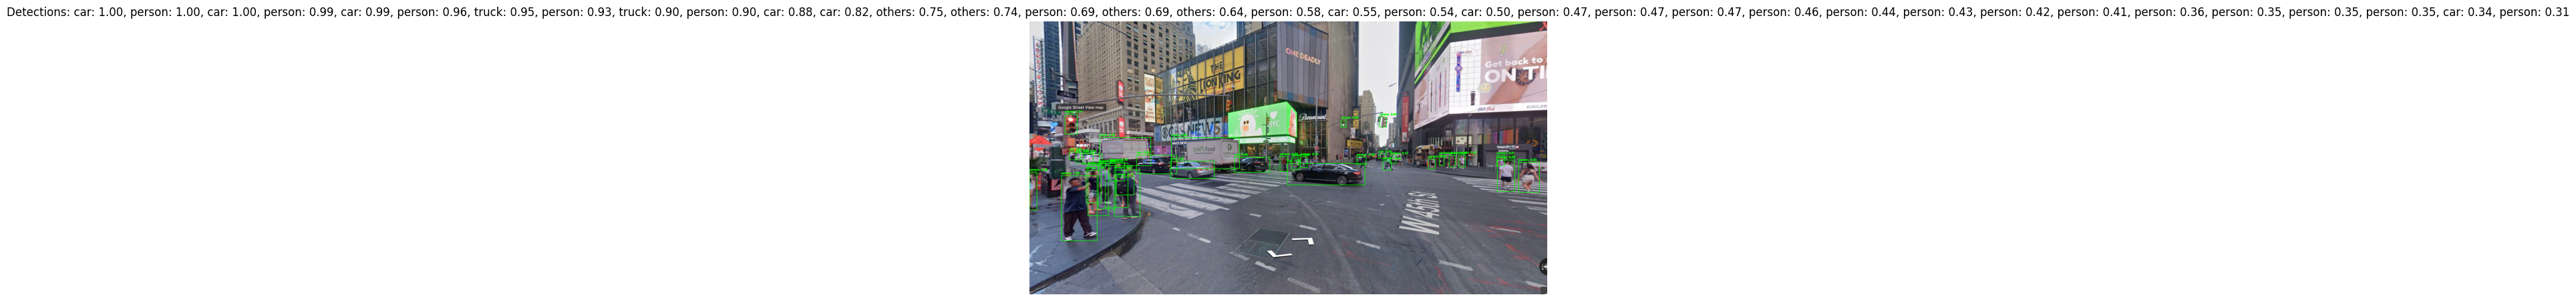

Result saved to detection_results/result_2.jpg

Results Table:
| Image | Detections | mAP |
|-------|------------|-----|
| personal_img1.webp | 15 | N/A |
| personal_img2.jpeg | 62 | N/A |


In [2]:
import os
import numpy as np
import tensorflow as tf
import cv2
import urllib.request
import time
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt

# VisDrone class names
VISDRONE_CLASSES = [
    'pedestrian', 'person', 'bicycle', 'car', 'van', 
    'truck', 'tricycle', 'awning-tricycle', 'bus', 'motor', 
    'others', 'plane', 'helicopter', 'boat', 'vehicle'
]

# Hyperparameters
class YOLOv3Config:
    def __init__(self):
        self.target_size = (416, 416)  # Input size for YOLOv3
        self.confidence_threshold = 0.3  # Confidence threshold for detections
        self.nms_threshold = 0.4  # Non-maximum suppression threshold
        self.batch_size = 1  # Batch size for inference
        self.weights_path = 'yolov3.weights'
        self.cfg_path = 'yolov3.cfg'

# Download YOLOv3 weights if needed
def download_yolov3_weights(weights_path='yolov3.weights'):
    if not os.path.exists(weights_path):
        print("Downloading YOLOv3 weights...")
        url = 'https://pjreddie.com/media/files/yolov3.weights'
        urllib.request.urlretrieve(url, weights_path)
        print("Download complete!")
    return weights_path

# Download YOLOv3 configuration if needed
def download_yolov3_cfg(cfg_path='yolov3.cfg'):
    if not os.path.exists(cfg_path):
        print("Downloading YOLOv3 configuration...")
        url = 'https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg'
        urllib.request.urlretrieve(url, cfg_path)
        print("Download complete!")
    return cfg_path

# Download COCO class names
def download_coco_names(names_path='coco.names'):
    if not os.path.exists(names_path):
        print("Downloading COCO class names...")
        url = 'https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names'
        urllib.request.urlretrieve(url, names_path)
        print("Download complete!")
    
    with open(names_path, 'r') as f:
        return [line.strip() for line in f.readlines()]

# Preprocessing function for images
def preprocess_image(image, config):
    orig_h, orig_w = image.shape[:2]
    resized = cv2.resize(image, config.target_size)
    blob = cv2.dnn.blobFromImage(
        resized, 
        1/255.0, 
        config.target_size, 
        [0, 0, 0], 
        True, 
        crop=False
    )
    return blob, (orig_h, orig_w)

# Load ground truth annotations for mAP calculatio
def load_ground_truth(annotations_path):
    ground_truth = []
    with open(annotations_path, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            if len(parts) >= 6:
                class_id = int(parts[5]) - 1  # VisDrone classes are 1-indexed
                if class_id < len(VISDRONE_CLASSES):
                    ground_truth.append({
                        'bbox': [int(parts[0]), int(parts[1]), int(parts[2]), int(parts[3])],
                        'class_id': class_id,
                        'score': float(parts[4])
                    })
    return ground_truth

# Compute mAP 
def compute_map(detections, ground_truth, num_classes):
    y_true = []
    y_scores = []
    for gt in ground_truth:
        gt_class = gt['class_id']
        gt_bbox = gt['bbox']
        matched = False
        for det in detections:
            det_class = det['class_id']
            det_bbox = det['bbox']
            det_conf = det['confidence']
            x1 = max(gt_bbox[0], det_bbox[0])
            y1 = max(gt_bbox[1], det_bbox[1])
            x2 = min(gt_bbox[0] + gt_bbox[2], det_bbox[0] + det_bbox[2])
            y2 = min(gt_bbox[1] + gt_bbox[3], det_bbox[1] + det_bbox[3])
            intersection = max(0, x2 - x1) * max(0, y2 - y1)
            union = gt_bbox[2] * gt_bbox[3] + det_bbox[2] * det_bbox[3] - intersection
            iou = intersection / union if union > 0 else 0
            
            if iou > 0.5 and gt_class == det_class:
                matched = True
                y_true.append(1)
                y_scores.append(det_conf)
                break
        if not matched:
            y_true.append(0)
            y_scores.append(0)

    ap_scores = []
    for class_id in range(num_classes):
        class_true = [1 if t == 1 and gt['class_id'] == class_id else 0 for t, gt in zip(y_true, ground_truth)]
        class_scores = [s if gt['class_id'] == class_id else 0 for s, gt in zip(y_scores, ground_truth)]
        if sum(class_true) > 0:
            ap = average_precision_score(class_true, class_scores)
            ap_scores.append(ap)
    
    return np.mean(ap_scores) if ap_scores else 0

# Detect objects in an image using OpenCV's DNN module
def detect_objects(image_path, config, annotations_path=None, visualize=False):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return None, None, None
    
    cfg_path = download_yolov3_cfg(config.cfg_path)
    weights_path = download_yolov3_weights(config.weights_path)
    class_names = download_coco_names()
    
    blob, original_size = preprocess_image(image, config)
    net = cv2.dnn.readNetFromDarknet(cfg_path, weights_path)
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)
    
    layer_names = net.getLayerNames()
    output_layer_indices = net.getUnconnectedOutLayers()
    if isinstance(output_layer_indices[0], (list, tuple)):
        output_layer_names = [layer_names[i[0] - 1] for i in output_layer_indices]
    else:
        output_layer_names = [layer_names[i - 1] for i in output_layer_indices]
    
    net.setInput(blob)
    start_time = time.time()
    outputs = net.forward(output_layer_names)
    end_time = time.time()
    
    print(f"Detection took {end_time - start_time:.3f} seconds")
    
    height, width = original_size
    boxes = []
    confidences = []
    class_ids = []
    detections = []
    
    for output in outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            
            if confidence > config.confidence_threshold:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
                
                detections.append({
                    'bbox': [x, y, w, h],
                    'class_id': class_id,
                    'confidence': confidence
                })
    
    indices = cv2.dnn.NMSBoxes(boxes, confidences, config.confidence_threshold, config.nms_threshold)
    result_image = image.copy()
    
    # Compute mAP if ground truth is provided
    map_score = None
    if annotations_path and os.path.exists(annotations_path):
        ground_truth = load_ground_truth(annotations_path)
        if ground_truth:
            map_score = compute_map(detections, ground_truth, len(VISDRONE_CLASSES))
            print(f"mAP Score: {map_score:.3f}")
    
    detection_summary = []
    if len(indices) > 0:
        print(f"Found {len(indices)} objects")
        if isinstance(indices, tuple):
            indices = indices[0]
        
        for i in indices:
            if isinstance(i, list) or isinstance(i, np.ndarray):
                i = i[0]
            x, y, w, h = boxes[i]
            cv2.rectangle(result_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            class_id = class_ids[i]
            confidence = confidences[i]
            
            if class_id < len(class_names):
                coco_class = class_names[class_id]
                if 'person' in coco_class.lower():
                    visdrone_class = 'person'
                elif coco_class.lower() in ['car', 'truck', 'bus']:
                    visdrone_class = coco_class.lower()
                elif coco_class.lower() in ['bicycle', 'motorcycle']:
                    visdrone_class = 'bicycle' if 'bicycle' in coco_class.lower() else 'motor'
                elif coco_class.lower() in ['airplane', 'aeroplane']:
                    visdrone_class = 'plane'
                elif coco_class.lower() in ['boat', 'ship']:
                    visdrone_class = 'boat'
                else:
                    visdrone_class = 'others'
                label = f"{visdrone_class}: {confidence:.2f}"
            else:
                label = f"Class {class_id}: {confidence:.2f}"
            
            detection_summary.append(label)
            cv2.putText(result_image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    else:
        print("No objects detected")
    
    # Optional visualization with matplotlib
    if visualize:
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        plt.title(f"Detections: {', '.join(detection_summary)}" if detection_summary else "No Detections")
        plt.axis('off')
        plt.show()
    
    return result_image, map_score, detections

# Process a batch of images (VisDrone or personal)
def process_images(image_paths, config, annotations_paths=None, visualize=False):
    output_dir = "detection_results"
    os.makedirs(output_dir, exist_ok=True)
    
    results = []
    map_scores = []
    
    for i, image_path in enumerate(image_paths):
        print(f"Processing image {i+1}: {os.path.basename(image_path)}")
        annotation_path = annotations_paths[i] if annotations_paths and i < len(annotations_paths) else None
        result_image, map_score, detections = detect_objects(
            image_path, 
            config,
            annotation_path,
            visualize=visualize
        )
        
        if result_image is not None:
            output_path = os.path.join(output_dir, f"result_{i+1}.jpg")
            cv2.imwrite(output_path, result_image)
            print(f"Result saved to {output_path}")
            results.append({
                'image_path': image_path,
                'output_path': output_path,
                'detections': detections,
                'map_score': map_score
            })
            if map_score is not None:
                map_scores.append(map_score)
    
    return results, np.mean(map_scores) if map_scores else None

# Process VisDrone images
def process_visdrone_images(data_folder, config, max_images=5):
    images_folder = os.path.join(data_folder, 'images')
    annotations_folder = os.path.join(data_folder, 'annotations')
    
    if not os.path.exists(images_folder):
        print(f"Images folder not found: {images_folder}")
        return [], None
    
    image_paths = []
    for ext in ['.jpg', '.jpeg', '.png']:
        for file in os.listdir(images_folder):
            if file.lower().endswith(ext):
                image_paths.append(os.path.join(images_folder, file))
    
    image_paths = image_paths[:max_images]
    annotations_paths = [
        os.path.join(annotations_folder, os.path.splitext(os.path.basename(img))[0] + '.txt')
        for img in image_paths
    ]
    
    print(f"Found {len(image_paths)} images. Processing up to {max_images}...")
    return process_images(image_paths, config, annotations_paths, visualize=False)

# Main function to run detection
def main(data_folder='VisDrone2019-DET-val', max_images=5, personal_image_paths=None):
    config = YOLOv3Config()
    
    print("YOLOv3 Hyperparameters:")
    print(f" - Target Size: {config.target_size}")
    print(f" - Confidence Threshold: {config.confidence_threshold}")
    print(f" - NMS Threshold: {config.nms_threshold}")
    print(f" - Batch Size: {config.batch_size}")
    
    results = []
    avg_map = None
    
    # Process personal images if provided
    if personal_image_paths:
        print("\nProcessing personal images...")
        results, avg_map = process_images(personal_image_paths, config, visualize=True)
    else:
        # Process VisDrone images
        print("\nProcessing VisDrone images...")
        if not os.path.exists(data_folder):
            potential_folders = [d for d in os.listdir() if 'visdrone' in d.lower() and os.path.isdir(d)]
            if potential_folders:
                data_folder = potential_folders[0]
                print(f"Found potential VisDrone folder: {data_folder}")
            else:
                print(f"Error: Cannot find VisDrone dataset folder. Please specify the correct path.")
                return []
        results, avg_map = process_visdrone_images(data_folder, config, max_images)
    
    # Print result table
    print("\nResults Table:")
    print("| Image | Detections | mAP |")
    print("|-------|------------|-----|")
    for result in results:
        image_name = os.path.basename(result['image_path'])
        num_detections = len(result['detections'])
        map_score = f"{result['map_score']:.3f}" if result['map_score'] is not None else "N/A"
        print(f"| {image_name} | {num_detections} | {map_score} |")
    
    if avg_map is not None:
        print(f"\nAverage mAP across all images: {avg_map:.3f}")
    
    return results

# Run detection when executed directly
if __name__ == "__main__":
    # Define personal image paths
    personal_image_paths = [
        'personal_img1.webp',
        'personal_img2.jpeg'
    ]
    
    if all(os.path.exists(path) for path in personal_image_paths):
        main(personal_image_paths=personal_image_paths)
    else:
        print("One or more personal image paths are invalid. Falling back to VisDrone dataset...")
        main(max_images=5)